In [130]:

import os
import inspect
import sys
sys.path.insert(0, "../")


from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 1
# mpl.rcParams['legend.fontsize'] = 13

# mpl.rcParams['axes.titlesize'] = 15
# mpl.rcParams['axes.labelsize'] = 13
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
# with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
with DatabaseHandler(logger,"../experiments/experiments.db") as dbHandler:

    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            # replace null in the column string by 0
            column = column.replace("null","0")
            # replace Infinity in the column string by np.inf
            column = column.replace("Infinity","np.inf")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        if len(exploded[column].tolist()) > 0:
            exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)
        else:
            exploded[new_column] = np.nan
            # set attack_epsilon
            exploded["attack_epsilon"] = np.nan

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss","boundary_loss_test"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","first_term_fair_errors","second_term_fair_errors","third_term_fair_errors","test_losses","data_model_adversarial_generalization_errors","gamma_robustness_es","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","first_term_fair_error","second_term_fair_error","third_term_fair_error","test_loss","data_model_adversarial_generalization_error","gamma_robustness","boundary_loss_test"] #
    # columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","second_term_fair_errors","test_losses","data_model_adversarial_generalization_errors"]
    # new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","second_term_fair_error","test_loss","data_model_adversarial_generalization_error"] #
    return explode_measures(df, new_columns, columns)
    

df_erm = explode_erm_measures(df_erm)

df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  99


In [132]:
def extract_first_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[0])])
def extract_second_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[-1])])
def extract_trace(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(sum(array))])

df2 = df_state_evolution.reset_index()


df2["sigmax_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_trace"] = df2.apply(lambda row: extract_trace(row, "sigmax_eigenvalues"), axis=1)

df2["sigmatheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_trace"] = df2.apply(lambda row: extract_trace(row, "sigmatheta_eigenvalues"), axis=1)

df2["xtheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_trace"] = df2.apply(lambda row: extract_trace(row, "xtheta_eigenvalues"), axis=1)

# columns = ["sigmax_first_ev","sigmax_second_ev","sigmax_trace","sigmatheta_first_ev","sigmatheta_second_ev","sigmatheta_trace","xtheta_first_ev","xtheta_second_ev","xtheta_trace"]

# for column in columns:
#     # apply mean and std to the new column
#     df_result = df2[column].apply(lambda x: pd.Series({"mean":x, "std":0}))
#     multiindex = pd.MultiIndex.from_product([[column], ['mean', 'std']], names=['', ''])
#     df_result.columns = multiindex
#     # Concatenate the original DataFrame with the computed values DataFrame
#     df2 = pd.concat([df2, df_result], axis=1)

# drop the original eigenvalues columns
df2 = df2.drop(columns=["sigmax_eigenvalues","sigmatheta_eigenvalues","xtheta_eigenvalues"])

df_state_evolution = df2

# df_state_evolution

In [133]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
version_choice = "98"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
51,3f75678c-1562-45bf-a404-37fc99ec2452,FeatureComparisons,816.135317,"[""Logistic""]",98,2024-01-15 13:50:19,1,20,"[0.1585, 0.2512, 0.3981, 0.631, 1.0, 1.5849, 2...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
52,d43ae27a-cf92-4261-a7d1-de5c9717f775,SweepTau,18.832836,"[""Logistic""]",98,2024-01-15 13:45:30,1,0,[100000],"[0.0, 0.1, 0.2, 0.3]",...,"[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...",null,0.01,1000,Sweep,1,"[""KFeaturesModel""]","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
50,5be9a8fb-4726-4f26-a255-8888c73def57,FeatureComparisons,435.645723,"[""Logistic""]",98,2024-01-15 11:48:45,1,20,"[0.1585, 0.2512, 0.3981, 0.631, 1.0, 1.5849, 2...","[0.0, 0.2]",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [134]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [135]:
experiment_loc = 1

# extract experiment by id "250fa46e-55cb-40d2-b503-11b38823235d"
# experiment_id = "d43ae27a-cf92-4261-a7d1-de5c9717f775"


# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

d43ae27a-cf92-4261-a7d1-de5c9717f775
Sweep
KFeaturesModel
['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___SweepTau']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity"]
SweepTau
['Logistic']


In [136]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"


In [137]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52143/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52143/3541688095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [138]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [139]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [140]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [141]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [142]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [143]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)


In [144]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [145]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                            mean   
alpha    epsilon tau  lam   problem_type attack_epsilon data_model_name                                                            
100000.0 0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10373.0   
                 0.10 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10369.0   
                 0.15 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10321.0   
                 0.20 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10298.0   
                 0.25 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10288.0   
...                                                                                                                          ...   
         0.3     1.30 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10362.0   
                 1.35 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10360.0   
                 1.40 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10363.0   
                 1.45 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10364.0   
                 1.50 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               10365.0   

                                                                                                                \
                                                                                                           std   
alpha    epsilon tau  lam   problem_type attack_epsilon data_model_name                                          
100000.0 0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 0.10 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 0.15 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 0.20 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 0.25 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
...                                                                                                         ..   
         0.3     1.30 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 1.35 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 1.40 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 1.45 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                 1.50 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   

                                                                                                           duration_state_evolution  \
                                                                                                                               mean   
alpha    epsilon tau  lam   problem_type attack_epsilon data_model_name                                                               
100000.0 0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                18.409988   
                 0.10 0.001 Logistic     0.2            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               

In [149]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/tau_experiment.pkl"):
    df.to_pickle("Pickles/tau_experiment.pkl")

# extracting the data

In [150]:
# get unique epsilons
epsilons = df.index.get_level_values(1).unique()
epsilons

Index([0.0, 0.1, 0.2, 0.3], dtype='float64', name='epsilon')

In [151]:
# get unique attack_epsilons
attack_epsilons = df.index.get_level_values(5).unique()
attack_epsilons

Index([0.2], dtype='float64', name='attack_epsilon')

In [152]:
# create a dictionary of dataframes for each data_model_name
epsilon_dict = {}
for epsilon in epsilons:

    eps_df = df.xs(epsilon, level="epsilon")

    

    

    taus = eps_df.index.get_level_values("tau").unique()
    adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
    generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
    boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values

    taus = np.array(taus)
    adversarial_error_0 = np.array(adversarial_error_0)
    generalization_error_0 = np.array(generalization_error_0)
    boundary_error_0 = np.array(boundary_error_0)

    eps_0_dict = {}
    eps_0_dict["taus"] = taus
    eps_0_dict["adversarial_error"] = adversarial_error_0
    eps_0_dict["generalization_error"] = generalization_error_0
    eps_0_dict["boundary_error"] = boundary_error_0


    epsilon_dict[epsilon] = eps_0_dict


# Figure saving

[0.14261519 0.1274508  0.11602171 0.10839578 0.10321169 0.0995266
 0.09679483 0.09469758 0.09304066 0.0917005  0.0905952  0.08966857
 0.08888085 0.08820321 0.08761421 0.08709761 0.0866409  0.08623428
 0.08586995 0.08554168 0.08524438 0.08497386 0.08472669 0.08449997
 0.08429126 0.08409851 0.08391995 0.08375408 0.0835996  0.08345536]
[0.14261323 0.12745024 0.11602152 0.1083957  0.10321165 0.09952658
 0.09679482 0.09469757 0.09304066 0.0917005  0.0905952  0.08966856
 0.08888085 0.08820321 0.08761421 0.08709761 0.0866409  0.08623427
 0.08586995 0.08554168 0.08524437 0.08497386 0.08472669 0.08449996
 0.08429126 0.08409851 0.08391995 0.08375408 0.0835996  0.08345536]
[0.14260996 0.12744905 0.11602106 0.1083955  0.10321155 0.09952652
 0.09679478 0.09469754 0.09304064 0.09170048 0.09059518 0.08966855
 0.08888084 0.0882032  0.0876142  0.08709761 0.08664089 0.08623427
 0.08586995 0.08554167 0.08524437 0.08497386 0.08472669 0.08449996
 0.08429125 0.0840985  0.08391995 0.08375408 0.08359959 0.083

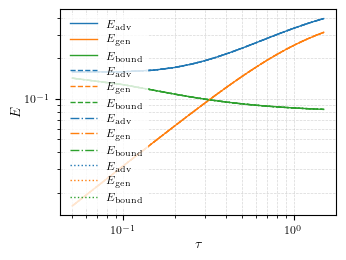

In [154]:

IMG_DIRECTORY = "./Assets/tau_sweeps"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


width = 1.25 * 458.63788

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=0.50)

multiplier = 0.9
second_multiplier = 0.7

fig, axs = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=True,
    figsize=(multiplier * tuple_size[0], 0.75 * multiplier * tuple_size[0]),
    gridspec_kw={"hspace": 0},
)


# ICML adjustments
# fig.subplots_adjust(left=0.16)
# fig.subplots_adjust(bottom=0.16)
# fig.subplots_adjust(top=0.97)
# fig.subplots_adjust(right=0.97)

linestyles = ["solid", "dashed", "dashdot", "dotted"]

for idx, (epsilon, eps_dict) in enumerate(epsilon_dict.items()):


    taus = eps_dict["taus"]
    adversarial_error = eps_dict["adversarial_error"]
    generalization_error = eps_dict["generalization_error"]
    boundary_error = eps_dict["boundary_error"]


    axs.plot(taus, adversarial_error, label=r"$E_{\mathrm{adv}}$", color="C0", linestyle=linestyles[idx])
    axs.plot(taus, generalization_error, label=r"$E_{\mathrm{gen}}$", color="C1", linestyle=linestyles[idx])
    axs.plot(taus, boundary_error, label=r"$E_{\mathrm{bound}}$", color="C2", linestyle=linestyles[idx])
    print(boundary_error)

axs.set_xscale("log")
axs.set_yscale("log")
axs.set_ylabel(r"$E$", labelpad=2.0)
axs.set_xlabel(r"$\tau$", labelpad=2.0)
axs.grid(which="both", axis="both", alpha=0.5)
axs.legend()

save = True
if save:
    save_plot(
        fig,
        "tau_sweep",
    )

plt.show()

In [ ]:


# let's extract the adversarial generalisation error, the boundary error and the generalisation error into a numpy array